<a href="https://colab.research.google.com/github/Albina1310/Albina1310/blob/main/%D0%A1%D0%B1%D0%BE%D1%80%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ поведения пользователей в мобильном приложении.

**Задача:** понять, как ведут себя пользователи мобильного приложения.

Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
Необходимо исследовать результаты **A/A/B-эксперимента** и выяснить какой шрифт лучше: Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План:**
1. Откроем файл с данными и изучим общую информацию
2. Подготовим данные (предобработка)
3. Изучим и проверим данные
4. Изучим воронку событий
5. Изучим результаты эксперимента


## Откроем файл с данными и изучим общую информацию

In [ ]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import math as mth
import warnings

warnings.filterwarnings('ignore')

In [ ]:
try:
    df = pd.read_csv('logs_exp.csv')
except:
    df = pd.read_csv("/datasets/logs_exp.csv", sep='\t')

In [ ]:
# посмотрим таблицу
display(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В данных более 244 тыс.записей событий. Видим, что дата стоит в "int", а нужно в типе "datetime", поэтому далее изменим в нужный нам тип данных и дабавим отдельный столбец с датой. Также изменим названия столбцов для удобного понимания и просмотра таблицы. Пропусков на первый взгляд нет, но мы это проверим в следующем шаге.

## Подготовим данные

In [ ]:
# проверяем на количество пропусков и дубликатов
print(f'Количество пропусков в таблице:\n{df.isna().sum()}')
print(f'Количество дубликатов в таблице: {df.duplicated().sum()}')

Количество пропусков в таблице:
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Количество дубликатов в таблице: 413


In [ ]:
# удалим явные дубликаты
df = df.drop_duplicates()

In [ ]:
# посмотрим на неявные дубликаты в колонке "EventName" с названиями событий
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Дубликатов явных и неявных больше нет.

In [ ]:
# меняем названия  колонок в таблице
df = df.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_date', 'ExpId': 'exp_id'})

In [ ]:
# поменяем типы данных в столбце с датой события
df['event_date'] = pd.to_datetime(df['event_date'], unit='s')

# добавим отдельный столбец с датой
df['date'] = df['event_date'].dt.date
display(df.head())

,event_name,user_id,event_date,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Вывод:** Данные подготовили к дальнейшим действиям. Названия колонок теперь читаемы и понятны. Дубликаты убрали, чтобы корректно проанализировать данные. Типы данных соответствуют требуемым, также отдельно добавили столбец с датой для удобства анализа.

## Изучим и проверим данные

In [ ]:
# посмотрим сколько всего событий в логе
print('Всего уникальных событий в колонке "event_name":', df['event_name'].nunique())

Всего уникальных событий в колонке "event_name": 5


In [ ]:
# посмотрим сколько пользователдей в логе
print('Всего уникальных пользователей в колонке "user_id":', df['user_id'].nunique())

Всего уникальных пользователей в колонке "user_id": 7551


In [ ]:
# посмотрим сколько в среднем приходится событий на одного пользователя
print('Среднее количество событий на одного пользователя:', round(df['event_name'].count()/df['user_id'].nunique()))

Среднее количество событий на одного пользователя: 32


In [ ]:
# посмотрим за какой период предоставлены данные
max_date = df['date'].max()
min_data =  df['date'].min()
print(f'Данные предоставлены с {min_data} по {max_date}')

Данные предоставлены с 2019-07-25 по 2019-08-07


Мы располагаем данными за 2 недели: с 25 июля 2019 года по 7 августа 2019 года. Построим график для понимания как события расположились по датам, одинаково ли данные распределены за весь период.

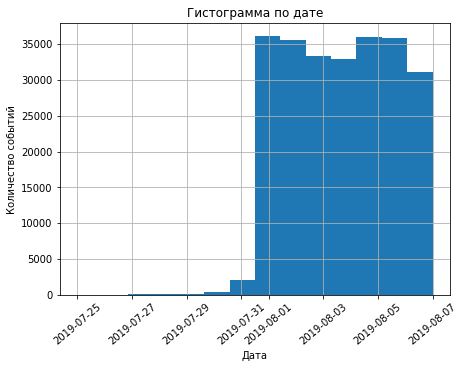

In [ ]:
# построим гистограмму по дате
df['date'].hist(bins=14, figsize=(7, 5)).set_title('Гистограмма по дате')
plt.ylabel("Количество событий")
plt.xlabel("Дата")
plt.xticks(rotation=40)
plt.show()

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»,  что мы и видим по графику. То есть на самом деле мы **располагаем данными с 1 - 7 августа 2019 года.** Не вошедшие в этот период мы отбросим и сохраним **в новом датафрейме "df_new"** - все что до 2019-08-01 уберем.

In [ ]:
# отбросим данные до первого августа
df['date'] = pd.to_datetime(df['date'])
df_new = df.query('date > "2019-07-31"')

# проверим сколько данных ушло
print('Потеряли в логе событий в количестве -', (df.shape[0] - df_new.shape[0]),', то есть осталось', (round((df_new.shape[0] / df.shape[0]*100), 1)),'процентов данных.')

Потеряли в логе событий в количестве - 2826 , то есть осталось 98.8 процентов данных.


Получается всего ушло 1,2% от общих данных. В целом можно считать, что на анализ в дальнейшем не повлияет это удаление, так как данных было убрано немного. Посмотрим сколько пользователей с данными ушло.

In [ ]:
# посмотрим сколько пользователдей в логе осталось
print('Всего осталось уникальных пользователей в колонке "user_id":', df_new['user_id'].nunique())
print('Потеряли пользователей в количестве -', (df['user_id'].nunique() - df_new['user_id'].nunique()))

Всего осталось уникальных пользователей в колонке "user_id": 7534
Потеряли пользователей в количестве - 17


In [ ]:
# посмотрим как распределены пользователи по группам
display(df_new.groupby('exp_id')['user_id'].nunique())

# посмотрим есть ли пользователи, участвовавшие в 3-х группах сразу
result = df_new.groupby('user_id')['exp_id'].apply(lambda x: set(x).issuperset({'246', '247', '248'}))
print(result[result == True].index.tolist())
print()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

[]



In [ ]:
# насколько группа 248 больше по количеству пользователей по сравнению с группой 246
print('На', round((100-(2484/2537*100)), 2),'% группа "248" больше группу "246" по количеству уникальных пользователей')

На 2.09 % группа "248" больше группу "246" по количеству уникальных пользователей


**Вывод:** Изучив данные мы выявили 5 событий в логе и 7551 пользователя. Но построив гистограмму по дате, обнаружили события из прошлых дней - в количестве 2826. Мы их убрали и создали новую таблицу, куда входят данные с 1-7 августа. Потеряли 17 пользователей и осталось 7534. В целом нами убрано 1,2% данных, что не повлияет на анализ в дальнейшем. Также убедились, что пользователи есть в каждой группе из 3-х. Есть расхождения в количестве пользователей по группам, так под номером "248" больше всего пользователей - 2537, а в "246" - 2484, получается между ними расхождение в 53 пользователя или в 2.09%. Таким образом **распределение по экпериментальным группам неравномерное**, расхождение более 1%, что уже является существенным и может повлиять на результаты анализа. Об сбое в распределении системы нужно сообщить разработчикам. В данных нет пользователей участвующих во всех 3 группах сразу или в двух (проверено).

## Изучим воронку событий

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


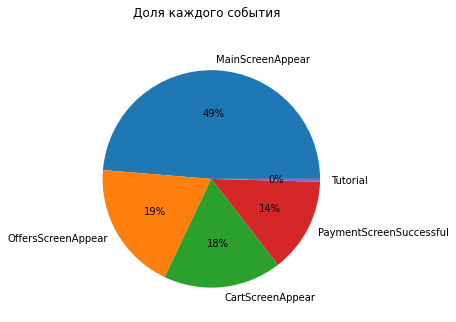

In [ ]:
# посмотрим каких событий больше, т.е. распределение данных по событиям
print(df_new['event_name'].value_counts())

# построим график и визуально оценим долю каждого события
fig,(ax1) = plt.subplots(figsize=(5, 5))
fig.suptitle('Доля каждого события', fontsize=12)
ax1.pie(df_new['event_name'].value_counts(), labels=df_new['event_name'].value_counts().index, autopct='%.0f%%');

Наибольшее число событий под названием "MainScreenAppear" - "Появляется главный экран", наименьшее у "Tutorial" - "Руководство". Более менее одинаково и равномерно распределены события "OffersScreenAppear" - "Появление экрана предложений", "CartScreenAppear" - "Появление экрана корзины", "PaymentScreenSuccessful" -"Экран оплаты - успешно". В воронку продаж не входит событие "Tutorial" - "Руководство", так как эти пользователи в процессе знакомства с приложением настраивали его под себя, либо были технические и другие проблемы, что никак не связано с продажей товара, поэтому мы его уберем из анализа воронки продаж.

Далее посмотрим как распределены пользователи по событиям, где их больше и их долю.

,user_id,share,conversion
event_name,,,
MainScreenAppear,7419,98.5,100.0
OffersScreenAppear,4593,61.0,62.0
CartScreenAppear,3734,49.6,81.0
PaymentScreenSuccessful,3539,47.0,95.0


Доля пользователей, которые проходят полную воронку событий, равна 47 процентов


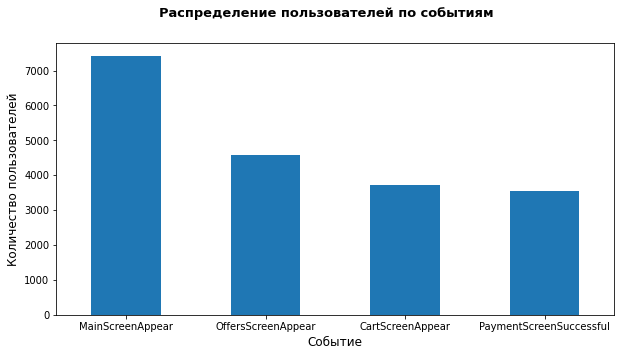

In [ ]:
# распределение пользователей по событиям и их доля в каждом из них
event_name_user = df_new.query('event_name != "Tutorial"').pivot_table(
    index = 'event_name', values = 'user_id', aggfunc='nunique').sort_values(by = 'user_id', ascending = False)
event_name_user['share'] = round(100*(event_name_user['user_id']/df_new['user_id'].nunique()), 1)
event_name_user['conversion'] = 0
for i in range(0, len(event_name_user['user_id'])):
    if i == 0:
        event_name_user['conversion'].iloc[i] = 100
    else:
        event_name_user['conversion'].iloc[i] = round((event_name_user['user_id'].iloc[i] / event_name_user['user_id'].iloc[i-1]), 2)*100
display(event_name_user)

# визуализируем распределение пользователей по событиям
event_name_user['user_id'].plot(kind='bar', figsize=(10, 5))
plt.suptitle('Распределение пользователей по событиям', fontsize=13, fontweight="bold")
plt.xlabel("Событие", fontsize=12)
plt.ylabel("Количество пользователей", fontsize=12)
plt.xticks(rotation=0);

# посмотрим долю пользователей, которые проходят полную воронку событий, от "главного экрана" до "покупки товара"
print('Доля пользователей, которые проходят полную воронку событий, равна', round(100*(3539/df_new['user_id'].nunique())), 'процентов')

**Вывод**: воронка продаж в приложении происходит в следующей последовательности:
1. "MainScreenAppear" - где 98.5% приходят в главный экран, т.е. у 1.5% есть технические либо другие проблемы при входе в приложение на главный экран.
2. "OffersScreenAppear" - 61% от общего числа (или 62% от первого шага "MainScreenAppear") заходят в экран с предложениями, а 38% о предыдущего шага не заинтерисовались товарами.
3. "CartScreenAppear" - 49.6% кладут товар в корзину от общего числа (или 81% от шага "OffersScreenAppear"). 19% пользователей "отвалились" от предыдущего шага.
4. "PaymentScreenSuccessful" - 47% оплачивают его от общего числа (или 95% от предыдущего шага "CartScreenAppear"), т.е. 5% пользователей "отвалились" от предыдущего шага и передумали покупать товар вложенный в корзину.

В воронку продаж не входит событие "Tutorial" - "Руководство", так как эти пользователи в процессе знакомства с приложением настраивали его под себя, либо были технические и другие проблемы, что никак не связано с продажей товара, поэтому мы его уберем из анализа воронки продаж.

Таким образом мы видим **наибольшее число пользователей покидают мобильное приложение на шаге "MainScreenAppear", т.е. когда они зашли на главный экран у 38% пользователей не возникло желания пройти и посмотреть предложения с товарами. Выходит не хватает "цепляющих глаз" предложений, либо неудобно расположены кнопки и пользователи не хотят разбираться в интерфейсе.**

В целом доля пользователей прошедших полную воронку продаж от первого до последнего шага составляет 47%, что достаточно высокий процент и можно считать мобильное приложение успешным. И чтобы этот процент вырос, нужно посмотреть причины отсеивания пользователей на первом этапе и устранения их.


## Изучим результаты эксперимента

In [ ]:
# еще раз посмотрим количество пользователей в каждой группе
exp_id = df_new.groupby('exp_id')['user_id'].nunique().to_frame()
display(exp_id)

,user_id
exp_id,
246,2484
247,2513
248,2537


Группа "246" меньше группу "247" на 29 пользователей, а между "246" и "248" уже разница выше в 53 пользователя (2,09%). Расхождения есть и об этом необходимо будет сообщить разработчикам, так как несбалансированно распределены пользователи.

In [ ]:
# процентное отношение числа пользователей группы "246" к группе "247"
print(f'Процентное отношение числа пользователей группы "246" к группе "247": {round(100-(2484*100/2513), 2)}%')


Процентное отношение числа пользователей группы "246" к группе "247": 1.15%


Получается группа "247" больше на 1.15%, чуть выше нормы в 1%. Таким образом разница несущественна и можно говорить о сбалансированном распределение между группами А/А теста.

In [ ]:
# сделаем таблицу, куда внесем разбивку по событиям в каждой группе
group_event = df_new.pivot_table(index = 'exp_id', columns = 'event_name', values = 'user_id', aggfunc='nunique')
group_event['total'] = [2484, 2513, 2537]
group_event

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
exp_id,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


Из таблицы видим, что популярное событие во всех групппах это "MainScreenAppear".

### Проверим равенство доли событий для групп "246" и "247".

Проведем **тест при помощи Z-критерия.**

**Нулевая гипотеза:** между долями нет значимой разницы.(равны доли)

**Альтернативная:** между долями есть значимая разница.(неравны доли)

alpha = 0.01

In [ ]:
# проведем тест для события MainScreenAppear в группах "246" и "247"
alpha = 0.01
event = np.array([2450, 2476])
total = np.array([2484, 2513])

p1 = event[0]/total[0]
p2 = event[1]/total[1]
p_combined = (event[0] + event[1]) / (total[0] + total[1])
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1])) # ваш код

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, т.е. между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 246-ой контрольной группе', round(group_event['MainScreenAppear'].iloc[0]/
                                           group_event['total'].iloc[0]*100, 2), '% пользователей переходят на главный экран')
print('В 247-ой контрольной группе', round(group_event['MainScreenAppear'].iloc[1]/
                                           group_event['total'].iloc[1]*100, 2), '% пользователей переходят на главный экран')

В 246-ой контрольной группе 98.63 % пользователей переходят на главный экран
В 247-ой контрольной группе 98.53 % пользователей переходят на главный экран


Таким образом разница событий в долях группы "246" и "247" не является статистически значимой.

Далее обернем наш тест в функцию и проделаем его с остальными событиями между группой "246" и "247"

In [ ]:
# функция для проведения Z-теста
def test_z (event, event1, total, total1):
    alpha = 0.01
    p1 = event/total
    p2 = event1/total1
    p_combined = (event + event1) / (total + total1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total + 1/total1)) # ваш код

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).')

In [ ]:
# проведем тест для события CartScreenAppear в группах "246" и "247"
test_z(1266, 1238, 2484, 2513)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события OffersScreenAppear в группах "246" и "247"
test_z(1542, 1520, 2484, 2513)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события PaymentScreenSuccessful в группах "246" и "247"
test_z(1200, 1158, 2484, 2513)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 246-ой контрольной группе', round(group_event['PaymentScreenSuccessful'].iloc[0]/group_event['total'].iloc[0]*100, 2), '% пользователей совершают покупку')
print('В 247-ой контрольной группе', round(group_event['PaymentScreenSuccessful'].iloc[1]/group_event['total'].iloc[1]*100, 2), '% пользователей совершают покупку')

В 246-ой контрольной группе 48.31 % пользователей совершают покупку
В 247-ой контрольной группе 46.08 % пользователей совершают покупку


**Итог:** Отвергнуть нулевую гипотезу не получилось, т.е. доли в воронке продаж между группами "246" и "247" равны. Проведение А/А теста между граппами "246" и "247" можно считать успешным и правильным. Но, что касается конверсии, то доля пользователей совершивших покупку в "246" группе выше, чем "247".

### Проверим равенство доли событий для групп "246" и "248".

In [ ]:
# проведем тест для события MainScreenAppear в группах "246" и "248"
test_z(2450, 2493, 2484, 2537)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 246-ой контрольной группе', round(group_event['MainScreenAppear'].iloc[0]/
                                           group_event['total'].iloc[0]*100, 2), '% пользователей переходят на главный экран')
print('В 248-ой группе, с измененным шрифтом', round(group_event['MainScreenAppear'].iloc[2]/
                                           group_event['total'].iloc[2]*100, 2), '% пользователей переходят на главный экран')

В 246-ой контрольной группе 98.63 % пользователей переходят на главный экран
В 248-ой группе, с измененным шрифтом 98.27 % пользователей переходят на главный экран


In [ ]:
# проведем тест для события CartScreenAppear в группах "246" и "248"
test_z(1266, 1230, 2484, 2537)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события OffersScreenAppear в группах "246" и "248"
test_z(1542, 1531, 2484, 2537)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события PaymentScreenSuccessful в группах "246" и "248"
test_z(1200, 1181, 2484, 2537)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 246-ой контрольной группе', round(group_event['PaymentScreenSuccessful'].iloc[0]/
                                           group_event['total'].iloc[0]*100, 2), '% пользователей совершают покупку')
print('В 248-ой группе, с измененным шрифтом', round(group_event['PaymentScreenSuccessful'].iloc[2]/
                                           group_event['total'].iloc[2]*100, 2), '% пользователей совершают покупку')

В 246-ой контрольной группе 48.31 % пользователей совершают покупку
В 248-ой группе, с измененным шрифтом 46.55 % пользователей совершают покупку


**Итог:** Отвергнуть нулевую гипотезу не получилось, т.е. доли в воронке продаж между группами "246" и "248" равны. Но, что касается конверсии, то доля пользователей совершивших покупку в "246" группе выше, чем "248" на 2%. Проведенный А/В тест между граппами "246" и "248" говорит о нецелесообразности изменения шрифта во всем приложении - он не дает нужных результатов.

### Проверим равенство доли событий для групп "247" и "248".

In [ ]:
# проведем тест для события MainScreenAppear в группах "247" и "248"
test_z(2476, 2493, 2513, 2537)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 247-ой контрольной группе', round(group_event['MainScreenAppear'].iloc[1]/
                                           group_event['total'].iloc[1]*100, 2), '% пользователей переходят на главный экран')
print('В 248-ой группе, с измененным шрифтом', round(group_event['MainScreenAppear'].iloc[2]/
                                           group_event['total'].iloc[2]*100, 2), '% пользователей переходят на главный экран')

В 247-ой контрольной группе 98.53 % пользователей переходят на главный экран
В 248-ой группе, с измененным шрифтом 98.27 % пользователей переходят на главный экран


In [ ]:
# проведем тест для события CartScreenAppear в группах "247" и "248"
test_z(1238, 1230, 2513, 2537)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события OffersScreenAppear в группах "247" и "248"
test_z(1520, 1531, 2513, 2537)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события PaymentScreenSuccessful в группах "247" и "248"
test_z(1158, 1181, 2513, 2537)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 247-ой контрольной группе', round(group_event['PaymentScreenSuccessful'].iloc[1]/
                                           group_event['total'].iloc[1]*100, 2), '% пользователей совершают покупку')
print('В 248-ой группе, с измененным шрифтом', round(group_event['PaymentScreenSuccessful'].iloc[2]/
                                           group_event['total'].iloc[2]*100, 2), '% пользователей совершают покупку')

В 247-ой контрольной группе 46.08 % пользователей совершают покупку
В 248-ой группе, с измененным шрифтом 46.55 % пользователей совершают покупку


**Итог:** Отвергнуть нулевую гипотезу не получилось, т.е. доли в воронке продаж между группами "247" и "248" равны. Но, что касается конверсии, то доля пользователей совершивших покупку в "247" и "248" группах примерно равны. Проведенный А/В тест между граппами "247" и "248" говорит о нецелесообразности изменения шрифта во всем приложении - он не дает нужных результатов.

### Проверим равенство доли событий для групп "248" и "249".

Добавим в таблицу новую группу "249", куда войдут данные первых групп А/А теста. Обьеденив их посмотрим изменится ли результат теста.

In [ ]:
row = group_event.loc[246] + group_event.loc[247]
row.name = '249'
group_event = group_event.append([row])
group_event = group_event[['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial', 'total']]
group_event

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537
249,2504,4926,3062,2358,561,4997


In [ ]:
# проведем тест для события MainScreenAppear в группах "248" и "249"
test_z(2493, 4926, 2537, 4997)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 248-ой группе, с измененным шрифтом', round(group_event['MainScreenAppear'].iloc[2]/
                                           group_event['total'].iloc[2]*100, 2), '% пользователей переходят на главный экран')
print('В 249-ой обьединенной группе', round(group_event['MainScreenAppear'].iloc[3]/
                                           group_event['total'].iloc[3]*100, 2), '% пользователей переходят на главный экран')

В 248-ой группе, с измененным шрифтом 98.27 % пользователей переходят на главный экран
В 249-ой обьединенной группе 98.58 % пользователей переходят на главный экран


In [ ]:
# проведем тест для события CartScreenAppear в группах "248" и "249"
test_z(1230, 2504, 2537, 4997)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события OffersScreenAppear в группах "248" и "249"
test_z(1531, 3062, 2537, 4997)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
# проведем тест для события PaymentScreenSuccessful в группах "248" и "249"
test_z(1181, 2358, 2537, 4997)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными (т.е. они равны).


In [ ]:
print('В 248-ой группе, с измененным шрифтом', round(group_event['PaymentScreenSuccessful'].iloc[2]/
                                           group_event['total'].iloc[2]*100, 2), '% пользователей совершают покупку')
print('В 249-ой обьединенной группе', round(group_event['PaymentScreenSuccessful'].iloc[3]/
                                           group_event['total'].iloc[3]*100, 2), '% пользователей совершают покупку')

В 248-ой группе, с измененным шрифтом 46.55 % пользователей совершают покупку
В 249-ой обьединенной группе 47.19 % пользователей совершают покупку


**Итог:** Отвергнуть нулевую гипотезу не получилось, т.е. доли в воронке продаж между группами "248" и "249" равны. Но, что касается конверсии, то доля пользователей совершивших покупку в "249" выше на 0,64%, чем в "248". Проведенный А/В тест между граппами "248" и "249" говорит о нецелесообразности изменения шрифта во всем приложении - он не дает нужных результатов.

## Выводы

В датасете имеются столбцы с названием события, ID пользователя, временем события и номером экспериментальной группы. Дата записана в неправильном формате. Видны такие события: 'Появление главного экрана', 'Появление экрана оплаты' и т д. События являются частью воронки продаж на сайте. В таблице были удалены дубликаты, откорректированы типы данных, добавлен столбец с данной. Пропуски в таблице отсутствуют
В логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения. В логе всего 7551 пользователь. В среднем на пользователя приходится 32 события, однако это число завышено из за больших выбросов. Чаще всего на пользователей приходится 0-30 событий.
До 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов. После удаления ранних данных были потеряно 2826 событий, что составляет около 1% от общего числа, 5 пользователей.
По 7.7-8к событий приходится на каждую эксперименальную группу.
Cобытия складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты. Предположительно, воронка продаж следующая:
пользователь видит главныф экран сайта
пользователь переходит на понравившийся ему товар
пользоватеь добавляет товар в корзину и переходит в нее
пользователь оплачивает заказ
Дополнительно имеется событие - обучение. Возможно, пользователя учат работать с сайтом. Но, судя по доле этого события, оно нре является обязательным на сайте. И только 4% пользователей переходят на эту страницу, поэтому она не входит в воронку продаж.
Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки, от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей. К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. От показа главного экрана до тоговой оплаты доходит 48 % пользователей.
В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей. Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными.Самым популярным событием, как и ожидалось, становится показ главного экрана сайта. С этого и начинается воронка продаж.
При уровне статистической значимости 0.1, между второй контрольной группой (247) и группой с измененными шрифтами (248) значимых различий нет, так и нет разницы между тестовой группой и объеиненной контрольной. А вот между группами 246 и 248 есть значимая разница в доле пользоватей, перешедших к корзине. У группы с измененными шрифтами процент перешедших к оплате 48% < 50% перешедших к оплате в первой контролной группе.
При измепнении уровня значимости на 0.05, значимой разницы между тестовой группой и всеми контрольными группами при всех событиях нет.
Для определения уровня значисти лучше проводить компьютерный анализ. Для альфа 0.1 контрольная группа показала себя лучше тестовой для события перехода на страницу корзины. В остальных событиях значимой разницы между группами нет. При уменьшении альфа значительной разницы между группами нет ни для каких событий. Можно сделать вывод, что текст на сайте менять не нужно. В лучшем случае конверсия не изменится. А доля перешедших к корзине пользователей может упасть.